In this notebook we will train a basic keras neural network.

The dataset will be small and use very little feature engineering.

The prediction target will be 0 or 1.
* 0 = the player did not win the race
* 1 = the player won the race

We will save the model along with the dummies and scaling params.

We will then load the model and apply it to the validation data.

Finally we will graph the betting results based on the predictions.

In [1]:
import pandas as pd
import numpy as np
import tensorflow

from cataclop.core import models
from cataclop.ml.preprocessing import append_hist, model_to_dict
from cataclop.ml.preprocessing import get_dummies, get_dummy_values, get_dummy_features
from cataclop.ml.exploration import random_race

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

2021-10-26 08:19:44.642990: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-26 08:19:44.645843: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Load up to 10000 races from the database

In [2]:
races = models.Race.objects.all().prefetch_related('player_set', 'session', 'session__hippodrome')

races = races.filter(
    #session__hippodrome__country__in=('FRA',),
    #category__in=('PLAT',),
    #sub_category__in=('HANDICAP',),
    start_at__gte='2019-01-01',
    start_at__lt='2019-12-31'
)

races = races[:20000]

hippodromes = models.Hippodrome.objects.all()
hippodromes = [ model_to_dict(hippo) for hippo in hippodromes ]

sessions = [race.session for race in races]
sessions = list( map(lambda s: model_to_dict(s), set(sessions)) )

def player_dict(p):
    d = model_to_dict(p)
    d.update({
        "horse_name": p.horse.name,
        "horse_breed": p.horse.breed,
        "horse_sex": p.horse.sex
    })
    return d
players = [ player_dict(p) for race in races for p in race.player_set.all() ]

races = [ model_to_dict(race) for race in races ]

print('{} races'.format(len(races)))

13110 races


Construct the dataframe

In [3]:
races_df = pd.DataFrame.from_records(races, index='id')
sessions_df = pd.DataFrame.from_records(sessions, index='id')
hippodromes_df = pd.DataFrame.from_records(hippodromes, index='id')
players_df = pd.DataFrame.from_records(players, index='id')

hippodromes_df.index.name = "hippodrome_id"
sessions_df.index.name = "session_id"
races_df.index.name = "race_id"

# optimize a bit the dataframe
for c in ['horse_breed', 'horse_sex']:
    players_df[c] = players_df[c].astype('category')

for c in ['category', 'condition_age', 'condition_sex', 'sub_category']:
    races_df[c] = races_df[c].astype('category')

for c in ['country']:
    hippodromes_df[c] = hippodromes_df[c].astype('category')

# join all the dataframes into one
sessions_df = sessions_df.join(hippodromes_df, on="hippodrome_id", lsuffix="_session", rsuffix="_hippo")
races_df = races_df.join(sessions_df, on="session_id", lsuffix="_race", rsuffix="_session")

df = players_df.join(races_df, on="race_id", lsuffix="_player", rsuffix="_race")

df.reset_index(inplace=True)
df.set_index(['id'], inplace=True)

df['winner_dividend'].fillna(0., inplace=True)
df['placed_dividend'].fillna(0., inplace=True)

NUM_HIST = 6
# append 6 columns of position history (hist_1_pos, hist_2_pos...)
# parse the horse 'musique' into those columns
# eg. '1a4a7d0' : hist_1_pos=1, hist_2_pos=4, hist_3_pos=7, hist_4_pos=10
df = append_hist(df, NUM_HIST)

df['victory_earnings'] = np.log(1+df['victory_earnings'].fillna(0))
df['placed_earnings'] = np.log(1+df['placed_earnings'].fillna(0))
df['prev_year_earnings'] = np.log(1+df['prev_year_earnings'].fillna(0))
df['year_earnings'] = np.log(1+df['year_earnings'].fillna(0))
df['prize'] = np.log(df['prize'].fillna(0)+1)

df['handicap_distance'] = df['handicap_distance'].fillna(0.0)
df['handicap_weight'] = df['handicap_weight'].fillna(0.0)
df['win'] = (df['position'] == 1).astype(np.float)

In [4]:
sorted(list(df.columns))

['age',
 'category',
 'code',
 'condition_age',
 'condition_sex',
 'country',
 'date',
 'declared_player_count',
 'distance',
 'earnings',
 'final_odds',
 'final_odds_offline',
 'final_odds_ref',
 'final_odds_ref_offline',
 'final_odds_ref_unibet',
 'final_odds_unibet',
 'handicap_distance',
 'handicap_weight',
 'herder_avg_winning_dividend',
 'herder_id',
 'herder_winning_rate',
 'hippodrome_id',
 'hist_1_days',
 'hist_1_pos',
 'hist_2_days',
 'hist_2_pos',
 'hist_3_days',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'horse_breed',
 'horse_id',
 'horse_name',
 'horse_sex',
 'imported_at_hippo',
 'imported_at_player',
 'imported_at_race',
 'imported_at_session',
 'is_first_timer',
 'is_racing',
 'jockey_avg_winning_dividend',
 'jockey_change',
 'jockey_id',
 'jockey_winning_rate',
 'music',
 'name',
 'num',
 'num_bis',
 'num_race',
 'num_session',
 'owner_id',
 'placed_2_count',
 'placed_3_count',
 'placed_count',
 'placed_dividend',
 'placed_dividend_offline',
 'placed

In [5]:
df.describe().transpose().sort_index()

,count,mean,std,min,25%,50%,75%,max
age,158764.0,5.053935e+00,1.957844e+00,2.000000,4.000000,5.000000e+00,6.000000e+00,1.500000e+01
declared_player_count,158764.0,1.299805e+01,3.154555e+00,3.000000,11.000000,1.300000e+01,1.600000e+01,2.400000e+01
distance,158764.0,2.351135e+03,6.978059e+02,800.000000,1900.000000,2.400000e+03,2.825000e+03,7.300000e+03
earnings,158764.0,6.648327e+06,1.704077e+07,0.000000,765000.000000,2.930750e+06,7.663000e+06,1.514322e+09
final_odds,154729.0,3.369209e+01,4.821130e+01,1.100000,7.600000,1.600000e+01,3.840000e+01,9.890000e+02
final_odds_offline,132858.0,3.031988e+01,3.641199e+01,1.100000,7.500000,1.600000e+01,3.800000e+01,9.990000e+02
final_odds_ref,148718.0,2.697436e+01,4.014667e+01,1.100000,7.900000,1.470000e+01,2.900000e+01,9.990000e+02
final_odds_ref_offline,128644.0,2.266934e+01,2.455030e+01,1.100000,8.200000,1.500000e+01,2.800000e+01,8.380000e+02
final_odds_ref_unibet,138200.0,2.813057e+01,3.463229e+01,1.100000,7.700000,1.560000e+01,3.340000e+01,2.548000e+02
final_odds_unibet,138610.0,3.067278e+01,3.848909e+01,1.100000,7.400000,1.590000e+01,3.690000e+01,2.547000e+02


Define the target and the features to feed our model 

In [6]:
df['position_log'] = np.log(1+df['position'])
TARGET = 'position_log'

FEATURES = [
    'race_count',
    'victory_count',
    'placed_count',
    'placed_2_count',
    'placed_3_count',
    'hist_1_days',
    'hist_2_days',
    'prize',
    'declared_player_count', 
    'age', 
    'earnings',
    'prev_year_earnings',
    'victory_earnings', 
    'placed_earnings', 
    'post_position',
    'handicap_weight',
    'handicap_distance'
] + ['hist_{}_pos'.format(h+1) for h in range(NUM_HIST)]

CATEGORICAL_FEATURES = [
    'category', 
    'sub_category', 
    'horse_breed',
    'horse_sex'
]

for feature in FEATURES:
    df[feature] = df[feature].fillna(0.)

# what I do before fine tuning the model is to inject the target into the features
# the model should pick it up and get REALLY good predictions
# uncomment the following line to test it
# FEATURES += [TARGET]

FEATURES + CATEGORICAL_FEATURES

['race_count',
 'victory_count',
 'placed_count',
 'placed_2_count',
 'placed_3_count',
 'hist_1_days',
 'hist_2_days',
 'prize',
 'declared_player_count',
 'age',
 'earnings',
 'prev_year_earnings',
 'victory_earnings',
 'placed_earnings',
 'post_position',
 'handicap_weight',
 'handicap_distance',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'category',
 'sub_category',
 'horse_breed',
 'horse_sex']

Show selected features for one race

In [8]:
random_race(df, list(set([TARGET, 'winner_dividend', 'placed_dividend', 'num', 'final_odds', 'music', 'position'])) + FEATURES + CATEGORICAL_FEATURES).sort_values('position')

final_odds  placed_dividend                 music  \
race_id id                                                          
76269   935236         4.1            120.0    1s(18)1s3s2s2s2h9h   
        935232         2.3            120.0                (18)1h   
        935237         3.7            120.0                    3h   
        935235        25.7              0.0  Ts(18)4s1sTh5h5h2h8h   
        935234         8.8              0.0                    2h   
        935238        50.1              0.0                (18)0p   
        935240        25.5              0.0                Inédit   
        935233        12.4              0.0      2h6h(18)9p3p4p6p   
        935239        36.4              0.0                Inédit   

                winner_dividend  position  position_log  num  race_count  \
race_id id                                                                 
76269   935236            370.0       1.0      0.693147    5           7   
        935232              0.0       2.0      1.098612    1           1   
        935237              0.0       3.0      1.386294    6           1   
        935235              0.0       4.0      1.609438    4           8   
        935234              0.0       5.0      1.791759    3           1   
        935238              0.0       6.0      1.945910    7           0   
        935240              0.0       7.0      2.079442    9           0   
        935233              0.0       NaN           NaN    2           2   
        935239              0.0       NaN           NaN    8           0   

                victory_count  placed_count  placed_2_count  placed_3_count  \
race_id id                                                                    
76269   935236              2             4               3               1   
        935232              1             0               0               0   
        935237              0             1               0               1   
        935235              1             4               1               0   
        935234              0             1               1               0   
        935238              0             0               0               0   
        935240              0             0               0               0   
        935233              0             1               1               0   
        935239              0             0               0               0   

                hist_1_days  hist_2_days     prize  declared_player_count  \
race_id id                                                                  
76269   935236         77.0         91.0  10.71444                      9   
        935232        175.0          0.0  10.71444                      9   
        935237         52.0          0.0  10.71444                      9   
        935235         46.0         67.0  10.71444                      9   
        935234         21.0          0.0  10.71444                      9   
        935238        268.0          0.0  10.71444                      9   
        935240          0.0          0.0  10.71444                      9   
        935233         26.0         36.0  10.71444                      9   
        935239          0.0          0.0  10.71444                      9   

                age  earnings  prev_year_earnings  victory_earnings  \
race_id id                                                            
76269   935236    4   6779000           15.112701         15.729340   
        935232    4    816000           13.612171         13.612171   
        935237    4    420000            0.000000         12.948012   
        935235    4   1655000           14.319312         14.319312   
        935234    4    624000            0.000000         13.343907   
        935238    4         0            0.000000          0.000000   
        935240    4         0            0.000000          0.000000   
        935233    4    720000            0.000000         13.4

Split our dataset into a training set and validation set

In [9]:
df_model = df[~df[TARGET].isna()].copy()
df_model['pred'] = 0
df_model['pred_prob'] = 0.
df_model['profit'] = 0.

race_ids = df_model['race_id'].unique()

# keep 1/5 of the dataset for validation
VALIDATION_NUM_SAMPLES = int(len(race_ids)/5)
race_ids_validation = race_ids[:VALIDATION_NUM_SAMPLES]
race_ids_train = race_ids[VALIDATION_NUM_SAMPLES:]

df_validation = df_model[df_model['race_id'].isin(race_ids_validation)].copy()
df_train = df_model[df_model['race_id'].isin(race_ids_train)].copy()

df_train.reset_index(inplace=True)
df_validation.reset_index(inplace=True)

print('{} train samples, {} validation samples'.format(len(df_train), len(df_validation)))

101444 train samples, 25617 validation samples


Check how unbalanced the dataset is

In [9]:
from collections import Counter
Counter(df_train[TARGET])

Counter({2.3978952727983707: 5534,
         1.6094379124341003: 10175,
         2.5649493574615367: 2838,
         2.1972245773362196: 8066,
         2.4849066497880004: 3961,
         0.6931471805599453: 10201,
         1.791759469228055: 10086,
         2.6390573296152584: 1883,
         1.0986122886681098: 10204,
         1.3862943611198906: 10193,
         2.0794415416798357: 9061,
         1.9459101490553132: 9753,
         2.302585092994046: 6815,
         2.70805020110221: 1235,
         2.772588722239781: 759,
         2.833213344056216: 439,
         2.8903717578961645: 160,
         2.9444389791664403: 66,
         2.995732273553991: 8,
         3.091042453358316: 2,
         3.044522437723423: 3,
         3.1780538303479458: 1,
         3.1354942159291497: 1})

In [10]:
df_train[FEATURES].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
race_count,101444.0,2.381305e+01,2.494562e+01,0.000000,5.000000,1.500000e+01,3.500000e+01,3.690000e+02
victory_count,101444.0,2.616941e+00,3.325670e+00,0.000000,0.000000,2.000000e+00,4.000000e+00,4.800000e+01
placed_count,101444.0,1.094316e+01,1.199274e+01,0.000000,2.000000,7.000000e+00,1.600000e+01,1.050000e+02
placed_2_count,101444.0,2.429311e+00,2.957553e+00,0.000000,0.000000,1.000000e+00,4.000000e+00,3.200000e+01
placed_3_count,101444.0,2.278903e+00,2.787528e+00,0.000000,0.000000,1.000000e+00,3.000000e+00,3.500000e+01
hist_1_days,101444.0,4.858860e+01,1.364720e+02,-934.000000,12.000000,2.200000e+01,4.700000e+01,2.145000e+03
hist_2_days,101444.0,8.310910e+01,1.630621e+02,-931.000000,24.000000,4.900000e+01,1.050000e+02,2.151000e+03
prize,101444.0,9.916566e+00,9.293073e-01,5.572154,9.546884,9.852247e+00,1.030899e+01,1.613827e+01
declared_player_count,101444.0,1.275961e+01,3.147147e+00,3.000000,10.000000,1.300000e+01,1.600000e+01,2.400000e+01
age,101444.0,4.880752e+00,1.953751e+00,2.000000,3.000000,4.000000e+00,6.000000e+00,1.500000e+01


In [97]:
np.log(100000)

11.512925464970229

Finally train a model on each kfold get the prediction for the other kfolds

In [124]:
import copy
import io
import h5py
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor as BaseKerasRegressor

class KerasRegressor(BaseKerasRegressor):
    
#    def __init__(self, build_fn=None, **sk_params):
#        sk_params['callbacks'] = []
#        super(BaseKerasRegressor, self).__init__(build_fn, **sk_params)

    """
    TensorFlow Keras API neural network classifier.

    Workaround the tf.keras.wrappers.scikit_learn.KerasClassifier serialization
    issue using BytesIO and HDF5 in order to enable pickle dumps.

    Adapted from: https://github.com/keras-team/keras/issues/4274#issuecomment-519226139
    """

    def __getstate__(self):
        state = self.__dict__
        
        if "model" in state:
            print(state)
            print(model.__dict__)
            model = state["model"]
            model_hdf5_bio = io.BytesIO()
            with h5py.File(model_hdf5_bio, mode="w") as file:
                model.save(file)
            state["model"] = model_hdf5_bio
            
            state_copy = copy.deepcopy(state)
            state["model"] = model
            return state_copy
        else:
            return state

    def __setstate__(self, state):
        if "model" in state:
            model_hdf5_bio = state["model"]
            with h5py.File(model_hdf5_bio, mode="r") as file:
                state["model"] = keras.models.load_model(file)
        self.__dict__ = state

In [73]:
X_train.shape[1]

52

In [128]:
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import log_loss, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone as clone
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier, MLPRegressor
#from cataclop.ml.keras import KerasRegressor
from xgboost import XGBRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_fn_factory(input_dim):
    def baseline_regressor():
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout

        model = Sequential()
        model.add(Dense(25, input_dim=input_dim, activation='relu'))
        model.add(Dropout(.2))
        model.add(Dense(5, input_dim=input_dim, activation='relu'))
        model.add(Dense(1, activation='relu'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model
    return baseline_regressor

def build_fn():
    model = Sequential()
    model.add(Dense(25, input_dim=52, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

K_FOLD=2

groups = df_train['race_id'].values
group_kfold = GroupKFold(n_splits=K_FOLD)

splits = list(group_kfold.split(df_train.values, df_train[TARGET].values, groups))

models = []


for train_index, test_index in splits:
    dummies = get_dummies(df_train.iloc[train_index], CATEGORICAL_FEATURES)
    
    X_train = df_train[FEATURES].iloc[train_index].copy()
    y_train = df_train[TARGET].iloc[train_index]
    
    df_dummies = get_dummy_values(df_train.iloc[train_index], dummies)
    X_train = pd.concat([X_train, df_dummies], axis=1)
    
    X_test = df_train[FEATURES].iloc[test_index].copy()
    y_test = df_train[TARGET].iloc[test_index]
    df_dummies = get_dummy_values(df_train.iloc[test_index], dummies)
    X_test = pd.concat([X_test, df_dummies], axis=1)
    
    # filter only the training set
    # train_balanced_idx = ((df_train.iloc[train_index]['position'] == 1) | (df_train.iloc[train_index]['position'] == 2))
    # X_train = X_train.loc[train_balanced_idx]
    # y_train = y_train.loc[train_balanced_idx]
    
    
    callbacks = [
        EarlyStopping(patience=20, monitor='loss')
    ]
    
    steps = [QuantileTransformer(), KerasRegressor(
        build_fn=build_fn_factory(X_train.shape[1]), 
        # 400
        epochs=50, 
        batch_size=32, 
        # callbacks = callbacks
        verbose=True)]
    
    X_train = X_train.values
    X_test = X_test.values
    
    pipeline = make_pipeline(*steps)
    pipeline.fit(X_train, y_train.values)
    
    p = pipeline.predict(X_test)
    
    idx = df_train.iloc[test_index].index
    
    df_train.loc[idx, 'pred'] = p
    
    models.append({
        'dummies': dummies,
        'pipeline': pipeline
    })
    
    
    
    

Epoch 1/50
1586/1586 [==============================] - 6s 4ms/step - loss: 0.5059
Epoch 2/50
1586/1586 [==============================] - 6s 4ms/step - loss: 0.2990
Epoch 3/50
1586/1586 [==============================] - 8s 5ms/step - loss: 0.2849
Epoch 4/50
1586/1586 [==============================] - 6s 4ms/step - loss: 0.2806
Epoch 5/50
1586/1586 [==============================] - 7s 4ms/step - loss: 0.2797
Epoch 6/50
1586/1586 [==============================] - 7s 4ms/step - loss: 0.2782
Epoch 7/50
1586/1586 [==============================] - 7s 4ms/step - loss: 0.2757
Epoch 8/50
1586/1586 [==============================] - 8s 5ms/step - loss: 0.2770
Epoch 9/50
1586/1586 [==============================] - 8s 5ms/step - loss: 0.2752
Epoch 10/50
1586/1586 [==============================] - 7s 5ms/step - loss: 0.2713
Epoch 11/50
1586/1586 [==============================] - 11s 7ms/step - loss: 0.2722
Epoch 12/50
1586/1586 [==============================] - 17s 10ms/step - loss: 0.274

1586/1586 [==============================] - 4s 3ms/step - loss: 0.2671
Epoch 48/50
1586/1586 [==============================] - 4s 3ms/step - loss: 0.2672
Epoch 49/50
1586/1586 [==============================] - 5s 3ms/step - loss: 0.2656
Epoch 50/50
1586/1586 [==============================] - 3s 2ms/step


Check the prediction for a random race

In [142]:
random_race(df_train, [TARGET, 'country', 'name', 'sub_category', 'position', 'final_odds', 'pred'])

position_log country    name         sub_category  position  \
race_id                                                                      
83422   60538      1.098612     FRA  BORELY  COURSE_A_CONDITIONS       2.0   
        60539      1.609438     FRA  BORELY  COURSE_A_CONDITIONS       4.0   
        60540      2.079442     FRA  BORELY  COURSE_A_CONDITIONS       7.0   
        60541      0.693147     FRA  BORELY  COURSE_A_CONDITIONS       1.0   
        60542      1.945910     FRA  BORELY  COURSE_A_CONDITIONS       6.0   
        60543      1.386294     FRA  BORELY  COURSE_A_CONDITIONS       3.0   
        60544      1.791759     FRA  BORELY  COURSE_A_CONDITIONS       5.0   

               final_odds      pred  
race_id                              
83422   60538         4.7  1.311252  
        60539         4.8  1.310095  
        60540        34.0  1.496232  
        60541         1.7  1.193072  
        60542        24.0  1.501559  
        60543        23.0  1.558628  
        60544        21.0  1.533890

In [79]:
df_train[df_train['race_id']==77940][[TARGET, 'num', 'music', 'country', 'name', 'sub_category', 'position', 'final_odds', 'pred']]

,position_log,num,music,country,name,sub_category,position,final_odds,pred
7845,1.609438,1,6a2aDa4a1a2a2a2a6a3a,DEU,GELSENKIRCHEN,INTERNATIONALE_AUTOSTART,4.0,8.2,1.548587
7846,1.098612,6,0a7a3a4a7a1a5a2a5a1a,DEU,GELSENKIRCHEN,INTERNATIONALE_AUTOSTART,2.0,3.0,1.682302
7847,1.791759,7,0a9aDaDa9a6aDaDa,DEU,GELSENKIRCHEN,INTERNATIONALE_AUTOSTART,5.0,25.4,1.919016
7848,1.386294,10,3a0a7aDa8a7a9a8a2a4a,DEU,GELSENKIRCHEN,INTERNATIONALE_AUTOSTART,3.0,9.0,1.639510
7849,0.693147,12,8aDa2a1a4a4a3aDa1a2a,DEU,GELSENKIRCHEN,INTERNATIONALE_AUTOSTART,1.0,2.9,1.573691


Create the bets: for each race we take the top prediction (except if the odds are really too high)

In [156]:
from tqdm import tqdm
import json

BETS_PER_RACE = 1

def bet_multi(df, training=True):
    multi = []
    races = df.groupby('race_id')
    for name, group in tqdm(races):
        if group['win'].max() != 1:
            continue
        
        top_pred = group.sort_values('pred', ascending=True)
        
        top2_correct = 0
        top2_correct_disorder = 0
        top3_correct = 0
        top3_correct_disorder = 0
        top4_correct = 0
        top4_correct_disorder = 0
        top2_in_4 = 0
        
        combo = []
        
        for n in range(len(top_pred)):
            if n >= 5:
                break
            player = top_pred.iloc[n]
            combo.append(int(player['num']))
            if player['position'] == n+1:
                if n < 2:
                    top2_correct = top2_correct + 1
                if n < 3:
                    top3_correct = top3_correct + 1
                if n < 4:
                    top4_correct = top4_correct + 1
            if player['position'] <= 2 and n < 2:
                top2_correct_disorder = top2_correct_disorder + 1
            if player['position'] <= 2 and n < 4:
                top2_in_4 = top2_in_4 + 1
            if player['position'] <= 3 and n < 3:
                top3_correct_disorder = top3_correct_disorder + 1
            if player['position'] <= 4 and n < 4:
                top4_correct_disorder = top4_correct_disorder + 1
                
        row = top_pred.iloc[0].copy()
        row['combo'] = json.dumps(combo)
        row['top2_correct'] = int(top2_correct == 2)
        row['top2_correct_disorder'] = int(top2_correct_disorder == 2)
        row['top3_correct'] = int(top3_correct == 3)
        row['top3_correct_disorder'] = int(top3_correct_disorder == 3)
        row['top4_correct'] = int(top4_correct == 4)
        row['top4_correct_disorder'] = int(top4_correct_disorder == 4)
        row['top2_in_4'] = int(top2_in_4 >= 2)
                
        multi.append(row)
    
    multi_df = pd.DataFrame(multi)
    multi_df.reset_index(inplace=True)
    
    return multi_df

def bet(df, training=True):
    bets = []
    multi = []
    races = df.groupby('race_id')
    for name, group in tqdm(races):
        if group['win'].max() != 1:
            continue
            
        top_pred = group.sort_values('pred', ascending=True)
            
        for n in range(BETS_PER_RACE):

            player = top_pred.iloc[n]

            # add custom conditions to bet on the top prediction
            #if top_pred['final_odds_ref'] > 40:
            #    continue

            if training and player['winner_dividend'] is None:
                continue

            player['profit'] = (-1 + player['winner_dividend']/100.0)
            player['profit_placed'] = (-1 + player['placed_dividend']/100.0)

            bets.append(player)
        
    bet_df = pd.DataFrame(bets)
    bet_df.reset_index(inplace=True)
    
    return bet_df
    

In [209]:
bets = bet(df_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10192/10192 [01:53<00:00, 89.95it/s]


In [157]:
bets_multi = bet_multi(df_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10192/10192 [19:49<00:00,  8.57it/s]


In [164]:
from cataclop.core.models import Race, BetResult


def bet_mutli_profit(bets_multi):
    bets_multi['profit_top2_correct'] = 0
    bets_multi['profit_top2_correct_disorder'] = 0
    bets_multi['profit_top3_correct'] = 0
    bets_multi['profit_top3_correct_disorder'] = 0
    bets_multi['profit_top4_correct'] = 0
    bets_multi['profit_top4_correct_disorder'] = 0
    bets_multi['profit_top2_in_4'] = 0

    for index, row in tqdm(bets_multi.iterrows(), total=bets_multi.shape[0]):
        race = Race.objects.get(pk=row['race_id'])
        combo = json.loads(row['combo'])

        has_2_sur_4 = False

        for r in race.betresult_set.order_by('type', '-dividend'):

            won = int(r.combo == combo[0:len(r.combo)])
            

            if r.type == 'E_COUPLE_GAGNANT' and bets_multi.loc[index, 'profit_top2_correct_disorder'] == 0:
                won = row['top2_correct_disorder']
                bets_multi.loc[index, 'profit_top2_correct_disorder'] = -1 + won * (r.dividend/100)

            elif r.type == 'E_TRIO' and bets_multi.loc[index, 'profit_top3_correct_disorder'] == 0:
                won = row['top3_correct_disorder']
                bets_multi.loc[index, 'profit_top3_correct_disorder'] = -1 + won * (r.dividend/100)

            elif r.type == 'E_TRIO_ORDRE' and bets_multi.loc[index, 'profit_top3_correct'] == 0:
                won = row['top3_correct']
                bets_multi.loc[index, 'profit_top3_correct'] = -1 + won * (r.dividend/100)

            elif r.type == 'E_MULTI' and bets_multi.loc[index, 'profit_top4_correct_disorder'] == 0:
                won = row['top4_correct_disorder']
                bets_multi.loc[index, 'profit_top4_correct_disorder'] = -1 + won * (r.dividend/100)

            elif r.type == 'E_DEUX_SUR_QUATRE' and bets_multi.loc[index, 'profit_top2_in_4'] == 0:
                #print(r.combo, combo[0:len(r.combo)])
                won = int(np.array_equal(np.sort(r.combo), np.sort(combo[0:len(r.combo)])))
                has_2_sur_4 = True
                if won:
                    bets_multi.loc[index, 'profit_top2_in_4'] = -1 + won * (r.dividend/100)

            elif r.type == 'E_QUARTE_PLUS' and bets_multi.loc[index, 'profit_top4_correct'] == 0:
                bets_multi.loc[index, 'profit_top4_correct'] = -1 + won * (r.dividend/100)

        if has_2_sur_4 and bets_multi.loc[index, 'profit_top2_in_4'] == 0:
            bets_multi.loc[index, 'profit_top2_in_4'] = -1
            
        


        


In [165]:
bet_mutli_profit(bets_multi)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10192/10192 [05:04<00:00, 33.48it/s]


In [147]:
from django.db import connections, connection
for conn in connections.all():
    conn.close_if_unusable_or_obsolete()
len(Race.objects.all())

109080

In [34]:
bets_multi.loc[1, 'profit_top2_in_4'] = 0

In [152]:
bets_multi['sub_category'].value_counts()

INCONNU                                        1867
COURSE_A_CONDITIONS                            1062
AUTOSTART                                       974
HANDICAP                                        713
HANDICAP_DIVISE                                 585
NATIONALE                                       374
A_RECLAMER                                      323
HANDICAP_CATEGORIE_DIVISE                       259
EUROPEENNE                                      235
APPRENTIS_LADS_JOCKEYS                          203
INTERNATIONALE_AUTOSTART                        169
AMATEURS                                        146
HANDICAP_DE_CATEGORIE                           143
NATIONALE_AUTOSTART                             121
EUROPEENNE_AUTOSTART                             84
GROUPE_I                                         79
AMATEURS_AUTOSTART                               73
COURSE_A_CONDITION_QUALIF_HP                     51
APPRENTIS_LADS_JOCKEYS_AUTOSTART                 47
GROUPE_II   

In [179]:
bb = bets_multi[(bets_multi['category']=='ATTELE') ].copy()
bb.reset_index(inplace=True)
bb[[
    'profit_top2_correct', 'profit_top2_correct_disorder', 
    'profit_top3_correct', 'profit_top3_correct_disorder', 
    'profit_top4_correct', 'profit_top4_correct_disorder', 'profit_top2_in_4']].describe()

,profit_top2_correct,profit_top2_correct_disorder,profit_top3_correct,profit_top3_correct_disorder,profit_top4_correct,profit_top4_correct_disorder,profit_top2_in_4
count,4253.0,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000
mean,0.0,0.133106,0.106113,0.726617,-0.030332,0.849494,0.261909
std,0.0,5.910922,6.029942,12.765658,0.171518,17.829712,2.522306
min,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.0,-1.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000
50%,0.0,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000
75%,0.0,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.200000
max,0.0,150.200000,380.000000,335.400000,0.000000,702.500000,34.200000


In [137]:
bb = bets_multi[(bets_multi['category']=='ATTELE')].copy()
bb.reset_index(inplace=True)

bb[[
    'top2_correct', 'top2_correct_disorder', 
    'top3_correct', 'top3_correct_disorder', 
    'top4_correct', 'top4_correct_disorder', 'top2_in_4']].describe()

,top2_correct,top2_correct_disorder,top3_correct,top3_correct_disorder,top4_correct,top4_correct_disorder,top2_in_4
count,3740.000000,3740.000000,3740.000000,3740.000000,3740.000000,3740.000000,3740.000000
mean,0.054011,0.100267,0.009626,0.051872,0.002941,0.039305,0.345989
std,0.226069,0.300396,0.097650,0.221798,0.054160,0.194345,0.475753
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [138]:
cols = ['race_id', 'combo', 'num_session', 'num_race', 'start_at', 'sub_category', 'category',
       'profit_top2_correct', 'profit_top2_correct_disorder', 
    'profit_top3_correct', 'profit_top3_correct_disorder', 
    'profit_top4_correct', 'profit_top4_correct_disorder', 'profit_top2_in_4'
       ]
bb[bb['top3_correct_disorder']==1]['profit_top3_correct_disorder'].describe()

count     194.000000
mean       41.662371
std       111.029941
min         0.000000
25%         7.600000
50%        16.450000
75%        35.575000
max      1157.800000
Name: profit_top3_correct_disorder, dtype: float64

<AxesSubplot:>

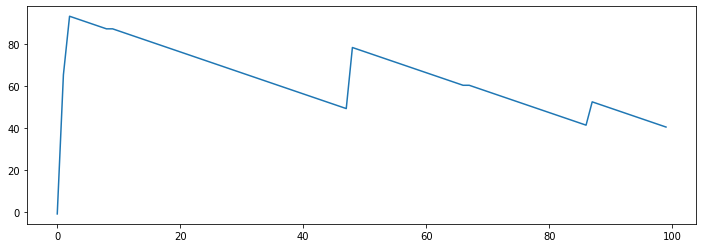

In [141]:
bb['profit_top3_correct_disorder'][0:100].cumsum().plot(figsize=(12, 4))

In [68]:
list(bb.index)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [272]:
len(bb[bb['top4_correct_disorder']==1])

168

In [211]:
bets[['profit', 'profit_placed']].describe()

,profit,profit_placed
count,10192.000000,10192.000000
mean,-0.097684,-0.030622
std,2.215679,1.168201
min,-1.000000,-1.000000
25%,-1.000000,-1.000000
50%,-1.000000,0.100000
75%,-1.000000,0.600000
max,41.600000,20.300000


In [229]:
bets['profit_placed_c'] = bets['profit_placed'] / np.log(bets['final_odds'].fillna(1))

In [172]:
bets['country'].value_counts()

FRA    7890
BEL     350
DEU     330
GBR     291
AAA     231
CHE     190
NLD     161
ESP     139
ZAF     109
CHL      74
AUT      69
ARG      60
NOR      52
BRA      48
ARE      41
SGP      40
PER      28
IRL      26
MAR      18
AUS      15
USA      14
SWE       9
FIN       6
JPN       1
Name: country, dtype: int64

In [232]:
bb = bets[(bets['final_odds']<20) & (bets['category']=='ATTELE')]['profit_placed']
bb.describe()

count    3863.000000
mean        0.044629
std         1.041165
min        -1.000000
25%        -1.000000
50%         0.200000
75%         0.700000
max         7.800000
Name: profit_placed, dtype: float64

Plot the evolution of our bank

<AxesSubplot:>

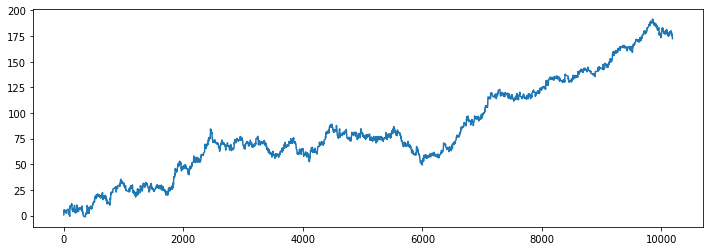

In [233]:
bb.cumsum().plot(figsize=(12, 4))

In [171]:
bb

3         0.4
4        16.0
5         0.8
6        14.6
7        -3.0
         ... 
10179    -3.0
10180    -3.0
10181     2.1
10182     1.2
10184     2.6
Name: profit, Length: 4253, dtype: float64

In [234]:
bets[['race_id', 'sub_category', 'position', 'final_odds_ref', 'pred', 'winner_dividend', 'placed_dividend', 'profit']]

,race_id,sub_category,position,final_odds_ref,pred,winner_dividend,placed_dividend,profit
0,77155,HANDICAP_DIVISE,4.0,5.7,1.773454,0.0,0.0,-1.0
1,77156,COURSE_A_CONDITION_QUALIF_HP,12.0,7.4,1.855387,0.0,0.0,-1.0
2,77157,HANDICAP_DIVISE,1.0,6.1,1.531507,470.0,180.0,3.7
3,77169,INCONNU,2.0,10.1,1.732401,0.0,170.0,-1.0
4,77170,INCONNU,2.0,3.1,1.354653,0.0,170.0,-1.0
...,...,...,...,...,...,...,...,...
10187,87457,COURSE_A_CONDITION_QUALIF_HP,3.0,3.1,1.438177,0.0,0.0,-1.0
10188,87458,INCONNU,7.0,2.9,1.271909,0.0,0.0,-1.0
10189,87459,COURSE_A_CONDITION_QUALIF_HP,1.0,6.7,1.349269,510.0,300.0,4.1
10190,87460,COURSE_A_CONDITION_QUALIF_HP,1.0,5.3,1.402310,290.0,150.0,1.9


In [103]:
bets[bets['profit']>0][['race_id', 'sub_category', 'position', 'final_odds_ref', 'pred', 'winner_dividend', 'placed_dividend', 'profit']]

,race_id,sub_category,position,final_odds_ref,pred,winner_dividend,placed_dividend,profit
0,75816,INCONNU,1.0,15.2,1.438224,750.0,350.0,6.5
1,75817,EUROPEENNE,1.0,16.7,0.787912,2650.0,420.0,25.5
3,75819,INCONNU,1.0,9.6,1.534961,780.0,180.0,6.8
4,75820,INCONNU,1.0,2.8,1.303863,260.0,130.0,1.6
7,75833,INCONNU,1.0,2.5,1.182522,200.0,160.0,1.0
...,...,...,...,...,...,...,...,...
4681,80671,INCONNU,1.0,1.9,1.055251,150.0,130.0,0.5
4700,80690,AUTOSTART,1.0,7.3,1.731202,540.0,190.0,4.4
4701,80691,INCONNU,1.0,9.7,1.279160,1270.0,420.0,11.7
4702,80692,AMATEURS,1.0,3.3,1.400336,260.0,140.0,1.6


When you're satisfied with the model, it's time to save it

In [129]:
import os
import shutil
from dill import dump, load

from cataclop.settings import BASE_DIR

model_dir = os.path.join(BASE_DIR, 'var/models/onboarding')

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
else:
    shutil.rmtree(model_dir)
    os.makedirs(model_dir)

path = os.path.join(model_dir, 'models.dill')
dump(models, open(path, 'wb+'))

{'build_fn': <function build_fn_factory.<locals>.baseline_regressor at 0x7faef1be6320>, 'sk_params': {'epochs': 50, 'batch_size': 32, 'verbose': True, 'callbacks': []}, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7faedfd82b90>}
{'build_fn': <function build_fn_factory.<locals>.baseline_regressor at 0x7faeec35e4d0>, 'sk_params': {'epochs': 50, 'batch_size': 32, 'verbose': True, 'callbacks': []}, 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7faede1e9f10>}


In [72]:
models

[{'dummies': {'category': ['PLAT',
    'ATTELE',
    'MONTE',
    'HAIE',
    'STEEPLECHASE',
    'CROSS'],
   'sub_category': ['INCONNU',
    'COURSE_A_CONDITIONS',
    'AUTOSTART',
    'HANDICAP',
    'HANDICAP_DIVISE',
    'A_RECLAMER',
    'HANDICAP_CATEGORIE_DIVISE',
    'NATIONALE',
    'EUROPEENNE',
    'INTERNATIONALE_AUTOSTART'],
   'horse_breed': ['PUR-SANG',
    'TROTTEUR FRANCAIS',
    'TROTTEUR ETRANGER',
    'AQPS',
    'ARABE',
    'ANGLO ARABE',
    'ANGLO ARABE DE COMPLEMENT',
    'INCONNU',
    'CHEVAL DE SELLE FRANCAIS',
    'CHEVAL DE SELLE'],
   'horse_sex': ['HONGRES', 'FEMELLES', 'MALES']},
  'pipeline': Pipeline(memory=None,
       steps=[('quantiletransformer', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
            output_distribution='uniform', random_state=None,
            subsample=100000)), ('kerasregressor', <cataclop.ml.keras.KerasRegressor object at 0x7faeed719f10>)])},
 {'dummies': {'category': ['PLAT',
    'ATTELE',


And we can import it to predict the validation set

In [130]:
%load_ext autoreload
%autoreload 2

import os
import shutil
from dill import dump, load
from tensorflow import keras

from cataclop.settings import BASE_DIR

model_dir = os.path.join(BASE_DIR, 'var/models/onboarding')

saved_models = load(open(os.path.join(model_dir, 'models.dill'), 'rb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
dummies = saved_models[0]['dummies']
pipeline = saved_models[0]['pipeline']

X_val = df_validation[FEATURES]
y_test = df_validation[TARGET]
df_dummies = get_dummy_values(df_validation, dummies)
X_val = pd.concat([X_val, df_dummies], axis=1)

p = pipeline.predict(X_val)

df_validation['pred'] = p

801/801 [==============================] - 3s 3ms/step


In [132]:
random_race(df_validation, ['country', 'name', 'sub_category', 'music', 'position', 'final_odds', 'pred'])

country       name         sub_category  \
race_id                                                 
77123   25198     FRA  COMPIEGNE  COURSE_A_CONDITIONS   
        25199     FRA  COMPIEGNE  COURSE_A_CONDITIONS   
        25200     FRA  COMPIEGNE  COURSE_A_CONDITIONS   
        25201     FRA  COMPIEGNE  COURSE_A_CONDITIONS   
        25202     FRA  COMPIEGNE  COURSE_A_CONDITIONS   
        25203     FRA  COMPIEGNE  COURSE_A_CONDITIONS   
        25204     FRA  COMPIEGNE  COURSE_A_CONDITIONS   
        25205     FRA  COMPIEGNE  COURSE_A_CONDITIONS   
        25206     FRA  COMPIEGNE  COURSE_A_CONDITIONS   
        25207     FRA  COMPIEGNE  COURSE_A_CONDITIONS   
        25208     FRA  COMPIEGNE  COURSE_A_CONDITIONS   
        25209     FRA  COMPIEGNE  COURSE_A_CONDITIONS   

                                    music  position  final_odds      pred  
race_id                                                                    
77123   25198      (18)4sAs1h3s1s1s1s5h1h       3.0         6.4  1.395238  
        25199    Ah(18)1h2h3h(17)5h4h7p6p       5.0        20.8  1.570532  
        25200    (18)1h1h(17)7p6p6p1p1p9p      10.0         3.2  1.335637  
        25201    2h(17)0hTs1h2h1h(16)1s2s       8.0        15.0  1.455948  
        25202      8h(18)4h4h6s5s2s1s3pTs       4.0        24.8  1.568640  
        25203      4hAh(17)5h1h0h1sTs3h2h       2.0         9.4  1.460261  
        25204  (18)3h1h(17)6sTs3s0h(16)3s      11.0        75.6  1.533307  
        25205      5h(18)0p3p5p4p9p3p3p3p       9.0        20.3  1.624735  
        25206    (18)3s3s1s1s5s1s(16)7s3s       7.0        19.6  1.485744  
        25207    (17)Ah3h1h1s1s1s(16)5h2h       1.0         3.5  1.605531  
        25208      5h(18)0s2s(17)1s1s7h6h       6.0        28.5  1.396956  
        25209    0h(18)As5sAs4s7h(17)7s4h      12.0       123.7  1.745076

Plot the evolution of our bank on the validation set

100%|██████████| 264/264 [00:02<00:00, 101.83it/s]


<AxesSubplot:>

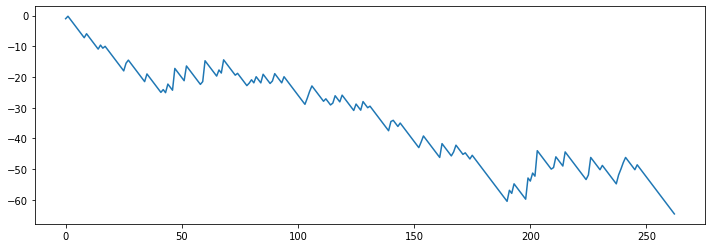

In [21]:
bets_val = bet(df_validation)
bets_val['profit'].cumsum().plot(figsize=(12, 4))

In [133]:
bets_multi_val = bet_multi(df_validation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2548/2548 [01:19<00:00, 32.12it/s]


In [134]:
bet_mutli_profit(bets_multi_val)

  0%|                                                                                                                                                                   | 0/1958 [00:00<?, ?it/s]/opt/pysetup/.venv/lib/python3.7/site-packages/numpy/core/numeric.py:2378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1958/1958 [00:23<00:00, 83.63it/s]


In [135]:
bb = bets_multi_val[(bets_multi_val['category']=='ATTELE')].copy()
bb.reset_index(inplace=True)
bb[[
    'profit_top2_correct', 'profit_top2_correct_disorder', 
    'profit_top3_correct', 'profit_top3_correct_disorder', 
    'profit_top4_correct', 'profit_top4_correct_disorder', 'profit_top2_in_4']].describe()

,profit_top2_correct,profit_top2_correct_disorder,profit_top3_correct,profit_top3_correct_disorder,profit_top4_correct,profit_top4_correct_disorder,profit_top2_in_4
count,895.0,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,0.0,0.016983,-0.004469,0.844916,-0.048045,2.356536,0.349832
std,0.0,4.274196,0.066740,12.588953,0.213980,28.872950,3.001014
min,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.0,-1.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000
50%,0.0,-1.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000
75%,0.0,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.700000
max,0.0,44.100000,0.000000,298.400000,0.000000,461.000000,38.300000


<AxesSubplot:>

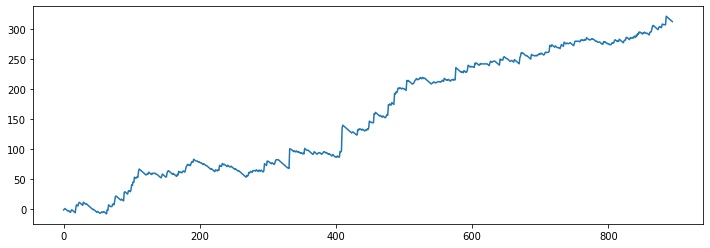

In [136]:
bb['profit_top2_in_4'].cumsum().plot(figsize=(12, 4))